# <font color=blue size=6>Challenge Telecom X: Análisis de evasión de clientes - Parte 2</font>



---

🎯 Misión

El objetivo es tener un modelo predictivo capaz de prever qué clientes tienen mayor probabilidad de cancelar sus servicios.

La empresa quiere anticiparse al problema de la cancelación, y debemos construir un pipeline robusto para esta etapa inicial de modelado.

🧠 <font color=red size=4>Este es un problema de clasificación binaria.</font>

🔷 Variable objetivo binaria (Churn = 1 o 0):
¿El cliente se irá o no?


✅ Modelos recomendados: Modelos de clasificación.

Probaremos:

*   DecisionTreeClassifier
*   RandomForestClassifier




---


🧠 Principales tareas del Desafío

Preparar los datos para el modelado (tratamiento, codificación, normalización).

Realizar análisis de correlación y selección de variables.

Entrenar dos o más modelos de clasificación.

Evaluar el rendimiento de los modelos con métricas.

Interpretar los resultados, incluyendo la importancia de las variables.

Crear una conclusión estratégica señalando los principales factores que influyen en la cancelación.


---



In [57]:
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

import seaborn as sns

from IPython.display import HTML, display

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.under_sampling import NearMiss

from scipy.stats import t

import pickle
import random
import warnings
warnings.filterwarnings('ignore')

In [58]:
# creo función para impresiones con características especiales
def big_print(text, size=20, color="black"):
    print("\n")
    display(HTML(f"<span style='font-size: {size}px; color: {color};'>{text}</span>"))

# <font color=blue size=5>Preparación de datos</font>

## <font color=blue size=5>Extracción del Archivo Normalizado del Challenge anterior</font>

In [59]:
# leemos archivo /content/df_normalizado.csv
df = pd.read_csv('/content/df_normalizado.csv')

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Churn             7043 non-null   object 
 2   gender            7043 non-null   object 
 3   SeniorCitizen     7043 non-null   int64  
 4   Partner           7043 non-null   object 
 5   Dependents        7043 non-null   object 
 6   tenure            7043 non-null   int64  
 7   PhoneService      7043 non-null   object 
 8   MultipleLines     7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  Contract          7043 non-null   object 


In [61]:
df.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40


In [62]:
# revisamos valores únticos de las columnas
for col in df.columns:
    print(f'{col}: {df[col].unique()}')

customerID: ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
Churn: ['No' 'Yes']
gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: ['Yes' 'No']
Dependents: ['Yes' 'No']
tenure: [ 9  4 13  3 71 63  7 65 54 72  5 56 34  1 45 50 23 55 26 69 37 49 66 67
 20 43 59 12 27  2 25 29 14 35 64 39 40 11  6 30 70 57 58 16 32 33 10 21
 61 15 44 22 24 19 47 62 46 52  8 60 48 28 41 53 68 31 36 17 18 51 38 42
  0]
PhoneService: ['Yes' 'No']
MultipleLines: ['No' 'Yes' 'No phone service']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['Yes' 'No' 'No internet service']
StreamingTV: ['Yes' 'No' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['One year' 'Month-to-month' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Mailed check' 'Electronic check' 'Credi

## <font color=blue size=5>Eliminación de Columnas Irrelevantes</font>

---
<font size=4>Análisis sobre la inclusión de **customerID** en modelos de predicción de Churn:

*   **customerID**: es  una columna generada para identificación de los registros, por lo que no representa información de las características de los clientes.</font>
---

In [63]:
# eliminamos columna customerID
df.drop('customerID', axis=1, inplace=True)
df.head(5)

,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40




---


<font size=4>Análisis sobre la inclusión de **tenure** en modelos de predicción de Churn:



*   **tenure** (tiempo como cliente) es resultado directo del churn, no su causa:
*   Si churn=1, tenure es el tiempo exacto hasta el abandono
*   En producción, no tendremos este valor para clientes activos
*   Incluirlo genera fuga de datos (data leakage): tenure = f(churn) - la variable contiene la respuesta</font>





---








In [64]:
# Eliminamos columna tenure
df.drop('tenure', axis=1, inplace=True)

In [65]:
# revisamos valores únicos de columnas
for col in df.columns:
    print(f'{col}: {df[col].unique()}')

Churn: ['No' 'Yes']
gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: ['Yes' 'No']
Dependents: ['Yes' 'No']
PhoneService: ['Yes' 'No']
MultipleLines: ['No' 'Yes' 'No phone service']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['Yes' 'No' 'No internet service']
StreamingTV: ['Yes' 'No' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['One year' 'Month-to-month' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Mailed check' 'Electronic check' 'Credit card (automatic)'
 'Bank transfer (automatic)']
Charges.Monthly: [65.6  59.9  73.9  ... 91.75 68.8  67.85]
Charges.Total: [ 593.3   542.4   280.85 ...  742.9  4627.65 3707.6 ]


## <font color=blue size=5>Encoding</font>

---
<font size=4>Codificamos Yes y No como 1 y 0 respectivamente

---


In [66]:
# transformamos valores binarios en 0 y 1 en las columnas correspondientes
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df['gender'] = df['gender'].map({'Female': 1, 'Male': 0})
df['Partner'] = df['Partner'].map({'Yes': 1, 'No': 0})
df['Dependents'] = df['Dependents'].map({'Yes': 1, 'No': 0})

df['PhoneService'] = df['PhoneService'].map({'Yes': 1, 'No': 0})
df['MultipleLines'] = df['MultipleLines'].map({'Yes': 1, 'No': 0, 'No phone service': 0})
df['OnlineSecurity'] = df['OnlineSecurity'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
df['OnlineBackup'] = df['OnlineBackup'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
df['DeviceProtection'] = df['DeviceProtection'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
df['TechSupport'] = df['TechSupport'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
df['StreamingTV'] = df['StreamingTV'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
df['StreamingMovies'] = df['StreamingMovies'].map({'Yes': 1, 'No': 0, 'No internet service': 0})

df['PaperlessBilling'] = df['PaperlessBilling'].map({'Yes': 1, 'No': 0})

In [67]:
df.head()

,Churn,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0,1,0,1,1,1,0,DSL,0,1,0,1,1,0,One year,1,Mailed check,65.6,593.30
1,0,0,0,0,0,1,1,DSL,0,0,0,0,0,1,Month-to-month,0,Mailed check,59.9,542.40
2,1,0,0,0,0,1,0,Fiber optic,0,0,1,0,0,0,Month-to-month,1,Electronic check,73.9,280.85
3,1,0,1,1,0,1,0,Fiber optic,0,1,1,0,1,1,Month-to-month,1,Electronic check,98.0,1237.85
4,1,1,1,1,0,1,0,Fiber optic,0,0,0,1,1,0,Month-to-month,1,Mailed check,83.9,267.40


---
<font size=4>Codificamos restantes columnas categórias con OneHotEncoder</font>

---


In [68]:
df.describe(include='object')

,InternetService,Contract,PaymentMethod
count,7043,7043,7043
unique,3,3,4
top,Fiber optic,Month-to-month,Electronic check
freq,3096,3875,2365


In [69]:
# Usamos el OneHotEncoder para transformar las columnas categóricas restantes

categoricas = ['InternetService', 'Contract', 'PaymentMethod']
one_hot_enc = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore', dtype=int),
    categoricas),
    remainder='passthrough')

df_codificados = one_hot_enc.fit_transform(df)
df_codificados = pd.DataFrame(df_codificados, columns=one_hot_enc.get_feature_names_out())

# Convertir todas las columnas a int donde solo haya 0 y 1
for col in df_codificados.columns:
    if set(df_codificados[col].unique()) <= {0.0, 1.0}:
        df_codificados[col] = df_codificados[col].astype(int)

In [70]:
df_codificados.head()

,onehotencoder__InternetService_DSL,onehotencoder__InternetService_Fiber optic,onehotencoder__InternetService_No,onehotencoder__Contract_Month-to-month,onehotencoder__Contract_One year,onehotencoder__Contract_Two year,onehotencoder__PaymentMethod_Bank transfer (automatic),onehotencoder__PaymentMethod_Credit card (automatic),onehotencoder__PaymentMethod_Electronic check,onehotencoder__PaymentMethod_Mailed check,...,remainder__MultipleLines,remainder__OnlineSecurity,remainder__OnlineBackup,remainder__DeviceProtection,remainder__TechSupport,remainder__StreamingTV,remainder__StreamingMovies,remainder__PaperlessBilling,remainder__Charges.Monthly,remainder__Charges.Total
0,1,0,0,0,1,0,0,0,0,1,...,0,0,1,0,1,1,0,1,65.6,593.30
1,1,0,0,1,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,59.9,542.40
2,0,1,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,73.9,280.85
3,0,1,0,1,0,0,0,0,1,0,...,0,0,1,1,0,1,1,1,98.0,1237.85
4,0,1,0,1,0,0,0,0,0,1,...,0,0,0,0,1,1,0,1,83.9,267.40


In [71]:
df_codificados.columns

Index(['onehotencoder__InternetService_DSL',
       'onehotencoder__InternetService_Fiber optic',
       'onehotencoder__InternetService_No',
       'onehotencoder__Contract_Month-to-month',
       'onehotencoder__Contract_One year', 'onehotencoder__Contract_Two year',
       'onehotencoder__PaymentMethod_Bank transfer (automatic)',
       'onehotencoder__PaymentMethod_Credit card (automatic)',
       'onehotencoder__PaymentMethod_Electronic check',
       'onehotencoder__PaymentMethod_Mailed check', 'remainder__Churn',
       'remainder__gender', 'remainder__SeniorCitizen', 'remainder__Partner',
       'remainder__Dependents', 'remainder__PhoneService',
       'remainder__MultipleLines', 'remainder__OnlineSecurity',
       'remainder__OnlineBackup', 'remainder__DeviceProtection',
       'remainder__TechSupport', 'remainder__StreamingTV',
       'remainder__StreamingMovies', 'remainder__PaperlessBilling',
       'remainder__Charges.Monthly', 'remainder__Charges.Total'],
      dtype='ob

In [72]:
# quitemos los prefijos 'onehotencoder__' de los nombres de las columnas
df_codificados.columns = df_codificados.columns.str.replace('onehotencoder__', '')

# eliminamos el prefijo 'remainder__'
df_codificados.columns = df_codificados.columns.str.replace('remainder__', '')

# revisemos los valores únicos de las columnas
for col in df_codificados.columns:
    print(f'{col}: {df_codificados[col].unique()}')

InternetService_DSL: [1 0]
InternetService_Fiber optic: [0 1]
InternetService_No: [0 1]
Contract_Month-to-month: [0 1]
Contract_One year: [1 0]
Contract_Two year: [0 1]
PaymentMethod_Bank transfer (automatic): [0 1]
PaymentMethod_Credit card (automatic): [0 1]
PaymentMethod_Electronic check: [0 1]
PaymentMethod_Mailed check: [1 0]
Churn: [0 1]
gender: [1 0]
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [1 0]
PhoneService: [1 0]
MultipleLines: [0 1]
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [1 0]
StreamingTV: [1 0]
StreamingMovies: [0 1]
PaperlessBilling: [1 0]
Charges.Monthly: [65.6  59.9  73.9  ... 91.75 68.8  67.85]
Charges.Total: [ 593.3   542.4   280.85 ...  742.9  4627.65 3707.6 ]


In [73]:
# guardamos archivo con datos codificados
df_codificados.to_csv('df_codificados.csv', index=False)

##<font color=blue size=5>Verificación de la Proporción de Cancelación (Churn)</font>

In [74]:
# a partir de hora trabajaremos con dataframe datos leído del csv guardado
df = pd.read_csv('/content/df_codificados.csv')

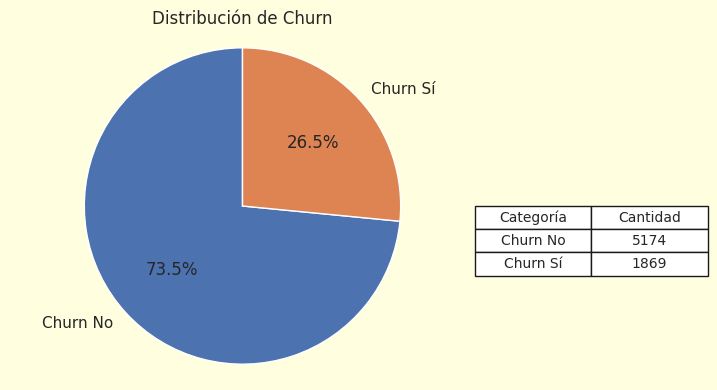

In [75]:
# creamos gráfico de torta con porcentajes y tabla con valores absolutos
sns.set(style="whitegrid")

# Contar los valores
valores = df['Churn'].value_counts()
etiquetas = ['Churn No', 'Churn Sí']
porcentajes = valores.values

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(6, 6))

# Cambiar el color de fondo
fig.patch.set_facecolor('lightyellow')   # Fondo de toda la figura
ax.set_facecolor('honeydew')             # Fondo del área del gráfico

# Gráfico de torta
wedges, texts, autotexts = ax.pie(
    porcentajes,
    labels=etiquetas,
    autopct='%1.1f%%',
    startangle=90
)
ax.axis('equal')  # Círculo perfecto

# Agregar tabla con valores absolutos
tabla_data = [[etiquetas[i], porcentajes[i]] for i in range(len(etiquetas))]
col_labels = ['Categoría', 'Cantidad']

tabla = ax.table(
    cellText=tabla_data,
    colLabels=col_labels,
    cellLoc='center',
    loc='bottom',
    bbox=[1.0, 0.3, 0.5, 0.2]  # [x, y, width, height]
)

tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
plt.title('Distribución de Churn')
plt.subplots_adjust(bottom=0.3)  # Espacio para la tabla

# plt.figtext(0.5, 0.25, 'Gráfico 1. Distribución de Churn', ha='center', va='bottom',
#            fontsize=12, fontweight='bold', fontstyle='italic', color='darkblue')

# guardamos gráfico como imagen png
plt.savefig('graf_01_torta_churn.png', dpi=300, bbox_inches='tight')

plt.show()

# <font color=blue size=5>Análisis de modelos</font>

<font color=red size=5>
Recordemos las fórmulas para el cálculo de las métricas de los modelos de clasificación</font>

<a href="https://imgbb.com/"><img src="https://i.ibb.co/6Jp6rKyC/Captura-de-tela-2025-03-22-120744.png" alt="Captura-de-tela-2025-03-22-120744" border="0"></a>

## <font color=blue size=5>DecisionTreeClassifier</font>

In [76]:
# Separación de variables dependiente e independientes
X = df.drop('Churn', axis=1)
y = df['Churn']

# Separación en Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# creamos modelo DecisionTreeClasifier
modelo = DecisionTreeClassifier(random_state=42,max_depth=10)

# entrenamos con conjunto de train
modelo.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1035
           1       0.54      0.53      0.53       374

    accuracy                           0.75      1409
   macro avg       0.68      0.68      0.68      1409
weighted avg       0.75      0.75      0.75      1409



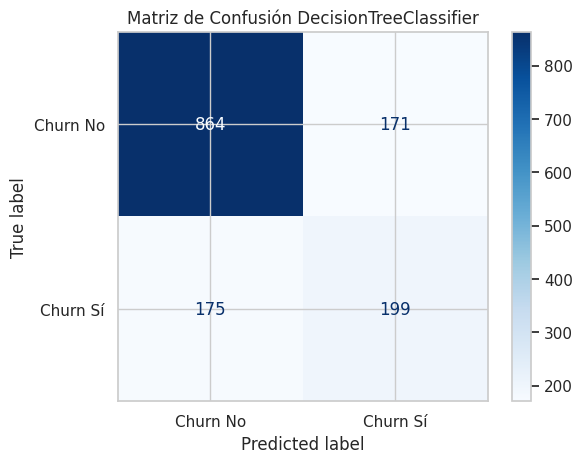

In [77]:
# revisemos las métricas y la matriz de confusión

y_previsto = modelo.predict(X_test)

big_print("Reporte de Clasificación DecisionTreeClassifier con datos sin balancear:", 20,'orange')

print(classification_report(y_test, y_previsto))

# creamos la matriz de confusión
cm = confusion_matrix(y_test, y_previsto)

# creamos el gráfico de la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Churn No', 'Churn Sí'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión DecisionTreeClassifier')
plt.show()

<font color=red size=4>
¿Qué significa esta matriz de confusión?</font>

1. que predijo correctamente 864 Churn No (Verdaderos Negativos TN) **83%**

2. que predijo erróneamente 171 Churn No como Churn Sí (Falsos Positivos FP)

3. predijo correctamente 199 Churn Sí (Verdaderos Positivos TP) **53%**

4. predijo erróneamente 175 Churn Sí como Churn No (Falsos Negativos FN)

Esto nos muestra que el modelo es prácticamente inútil para predecir correctamente los Churn Sí ya que solo identifica correctamente al 53% de ellos a pesar de que identifica correctamente a casi al 83% de los Churn No.

Este modelo no es útil porque nuestro objetivo es identificar lo mejor posible los clientes con Churn Sí.

**Nuestro objetivo es encontrar un modelo donde el recall para Churn Sí sea el mayor posible.**


---



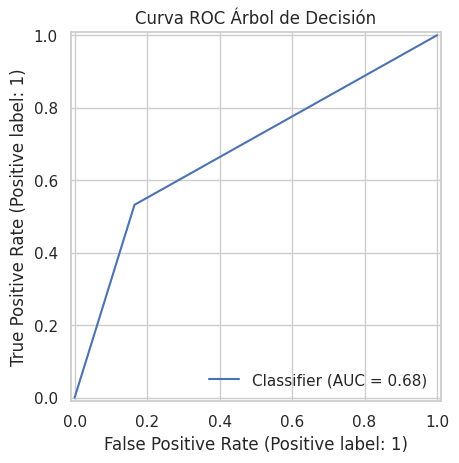

In [78]:
# revisemos la curva AUC para este modelo
RocCurveDisplay.from_predictions(y_test, y_previsto)
plt.title('Curva ROC Árbol de Decisión')
plt.show()

###<font color=red size=4> Validación cruzada de DecisionTreeClassifier </font>

In [79]:
# revisemos una validación cruzada de este modelo con Kfold
# generamos el modelo nuevamente usando Kfold

modelo = DecisionTreeClassifier(random_state=42, max_depth=10)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(modelo, X_train, y_train, cv=kf, scoring=['accuracy', 'precision', 'recall', 'f1'])


In [80]:
cv_resultados = pd.DataFrame(cv_results)
cv_resultados

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
0,0.035857,0.014917,0.755102,0.521277,0.510417,0.515789
1,0.034334,0.014306,0.784383,0.555556,0.581818,0.568384
2,0.035981,0.015543,0.761313,0.582524,0.562500,0.572337
3,0.030967,0.019457,0.755102,0.540453,0.554817,0.547541
4,0.034084,0.016590,0.739787,0.531690,0.485531,0.507563


              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1035
           1       0.54      0.53      0.53       374

    accuracy                           0.75      1409
   macro avg       0.68      0.68      0.68      1409
weighted avg       0.75      0.75      0.75      1409



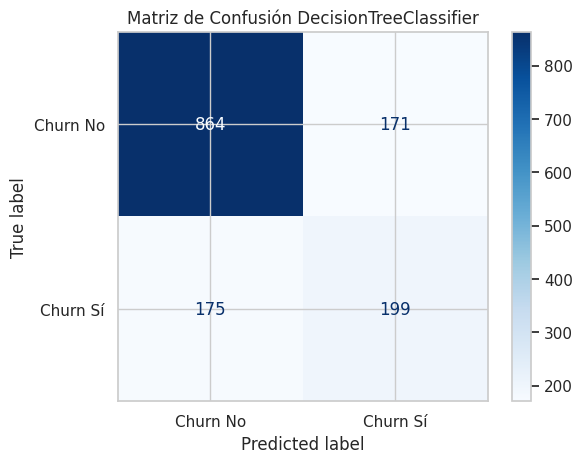

In [81]:
# entrenamos el modelo
modelo.fit(X_train, y_train)

# revisemos las métricas y la matriz de confusión
y_previsto = modelo.predict(X_test)

big_print("Reporte de Clasificación DecisionTreeClassifier:",20,'orange')
print(classification_report(y_test, y_previsto))

# creamos la matriz de confusión
cm = confusion_matrix(y_test, y_previsto)

# creamos el gráfico de la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Churn No', 'Churn Sí'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión DecisionTreeClassifier')
plt.show()

<font color=red size=4>
¿Qué significa esta matriz de confusión?</font>

1. que predijo correctamente 864 Churn No (Verdaderos Negativos TN) **83%**

2. que predijo erróneamente 171 Churn No como Churn Sí (Falsos Positivos FP)

3. predijo correctamente 199 Churn Sí (Verdaderos Positivos TP) **53%**

4. predijo erróneamente 175 Churn Sí como Churn No (Falsos Negativos FN)



---

<font color=red size=3>Estas métricas son iguales a las del modelo creado sin validación cruzada</font>




---



In [82]:
# revisemos el intervalo de confianza de este modelo

def intervalo_confianza_recall(recall_scores, confidence=0.95):
    recalls = np.array(recall_scores)
    mean = np.mean(recalls)
    std_err = np.std(recalls, ddof=1) / np.sqrt(len(recalls))
    t_crit = t.ppf((1 + confidence) / 2, df=len(recalls) - 1)
    margin_error = t_crit * std_err
    lower = round(float(mean - margin_error), 2)
    upper = round(float(mean + margin_error), 2)
    big_print(f"\nPromedio del recall: {mean:.2f}")
    big_print(f"\nIntervalo de confianza del recall: ({lower}, {upper})\n")

In [83]:
intervalo_confianza_recall(cv_resultados['test_recall'])

---
<font color=red size=4>
El promedio del recall es de 54%  

<font color=red size=4>
y el intervalo de confianza está entre el 49% y el 59%

(para una nivel de confianza deseado del 95%)</font>


<font color=red size=4>
Esto nos indica que entre el 49% y el 59% serán clasificados correctamente.

Esto es un nivel de confianza muy bajo
</font>



---

### <font color=blue size=5>Balanceo de Clases</font>

Sabemos que las clases Churn Sí y Churn No están muy desbalanceadas.

Reformulamos modelo balanceando las clases

#### <font color=blue size=5>Oversampling</font>

In [84]:
# ya sabemos que los datos tienen dos clases muy desbalanceadas
df['Churn'].value_counts(normalize=True)

,proportion
Churn,
0,0.73463
1,0.26537


In [85]:
# elegimos sobremuestreo para la clase minoritaria porque el volumen de información es suficiente
# para no generar ruido.
# aplicamos SMOTE sobre el conjunto de train

big_print(f"Distribución antes de SMOTE (Churn No - Churn Sí): {np.bincount(y_train)}",20)

# creamos X_balanceada e y_balanceada
X_bal, y_bal = SMOTE(random_state=42).fit_resample(X_train, y_train)

big_print(f"Distribución después de SMOTE (Churn No - Churn Sí): {np.bincount(y_bal)}")


In [86]:
# Entrenamos el modelo con los datos balaceados
modelo = DecisionTreeClassifier(max_depth=10, random_state=42)
modelo.fit(X_bal, y_bal)

DecisionTreeClassifier(max_depth=10, random_state=42)

              precision    recall  f1-score   support

           0       0.86      0.79      0.83      1035
           1       0.53      0.66      0.59       374

    accuracy                           0.76      1409
   macro avg       0.70      0.72      0.71      1409
weighted avg       0.78      0.76      0.76      1409



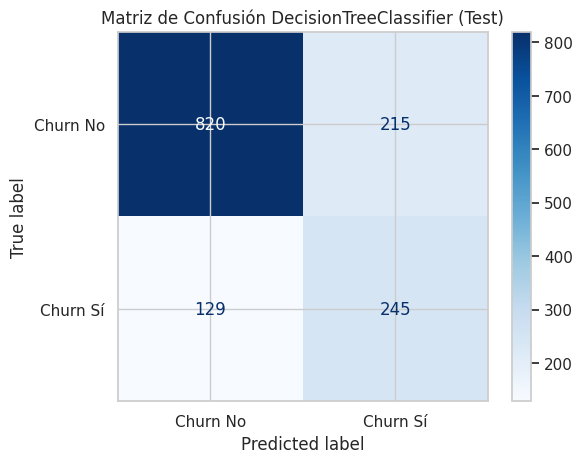

In [87]:
# revisemos las métricas y la matriz de confusión

# Evaluamos en test
y_previsto = modelo.predict(X_test)

y_proba = modelo.predict_proba(X_test)[:, 1]  # Probabilidad de clase positiva

big_print("Reporte de Clasificación DecisionTreeClassifier entrenado con datos balanceados:",20,'orange')
print(classification_report(y_test, y_previsto))

# creamos la matriz de confusión
cm = confusion_matrix(y_test, y_previsto)

# creamos el gráfico de la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Churn No', 'Churn Sí'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión DecisionTreeClassifier (Test)')
plt.show()

<font color=red size=4>
¿Qué significa esta matriz de confusión con datos balanceados?</font>

1. que predijo correctamente 820 Churn No (Verdaderos Negativos TN) **79%**

2. que predijo erróneamente 215 Churn No como Churn Sí (Falsos Positivos FP)

3. predijo correctamente 245 Churn Sí (Verdaderos Positivos TP) **66%**

4. predijo erróneamente 129 Churn Sí como Churn No (Falsos Negativos FN)

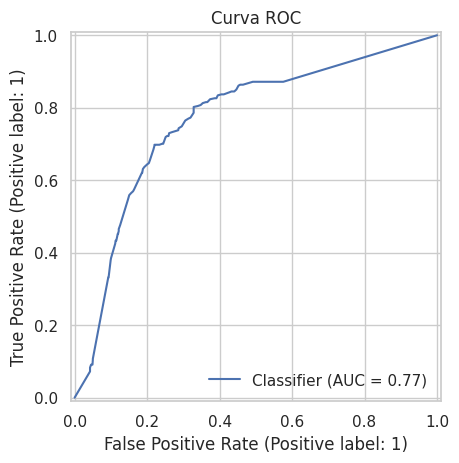

In [88]:
roc_auc = roc_auc_score(y_test, y_proba)
big_print(f"ROC AUC Score: {roc_auc:.2f}",20)

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("Curva ROC")
plt.show()


In [89]:
# revisemos el intervalo de confianza del recall

def bootstrap_recall(y_true, y_pred, n_bootstraps=1000, ci=0.95, seed=42):
    np.random.seed(seed)
    recalls = []
    size = len(y_true)

    for _ in range(n_bootstraps):
        indices = np.random.randint(0, size, size)
        y_true_sample = y_true[indices]
        y_pred_sample = y_pred[indices]
        recalls.append(recall_score(y_true_sample, y_pred_sample))

    lower = np.percentile(recalls, ((1 - ci) / 2) * 100)
    upper = np.percentile(recalls, (1 - (1 - ci) / 2) * 100)

    return np.mean(recalls), (lower, upper)

In [90]:
y_test_array = np.array(y_test)
y_previsto_array = np.array(y_previsto)

recall_mean, recall_ci = bootstrap_recall(y_test_array, y_previsto_array)

big_print(f"\nRecall promedio: {recall_mean:.2f}",20)
big_print(f"\nIntervalo de confianza del recall (95%): ({recall_ci[0]:.2f}, {recall_ci[1]:.2f})\n",20)

---
<font color=red size=4>
Con el modelo entrenado con un conjunto balanceado el promedio del recall es de 66%  

<font color=red size=4>
y el intervalo de confianza está entre el 61% y el 71%

(para una nivel de confianza deseado del 95%)</font>


<font color=red size=4>
Esto nos indica que entre el 61% y el 71% serán clasificados correctamente.

Esto es un nivel de confianza bastante mejor que el modelo entrenado con los datos desbalanceados
</font>



---

#### <font color=blue size=5>Pipeline de DecisionTreeClassifier con SMOTE y validación cruzada</font>

In [91]:
# creamos pipeline con balanceo de datos y validación cruzada

modelo = DecisionTreeClassifier(max_depth=10,random_state=42)

# creamos lista de tareas del pipeline
tareas = [('oversample', SMOTE(random_state=42)), ('Árbol', modelo)]

# creamos pipeline
pipeline = imbpipeline(tareas)

# instanciamos el StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = ['accuracy', 'precision', 'recall', 'f1']
cv_results = cross_validate(pipeline, X_train, y_train, cv=skf, scoring=scoring)

In [92]:
cv_resultados = pd.DataFrame(cv_results)
cv_resultados

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
0,0.053049,0.011703,0.740018,0.508621,0.591973,0.547141
1,0.052297,0.012302,0.780834,0.572626,0.685619,0.624049
2,0.051962,0.012174,0.748004,0.522124,0.591973,0.554859
3,0.050272,0.013490,0.763975,0.547009,0.642140,0.590769
4,0.051389,0.011474,0.738899,0.506887,0.615385,0.555891


In [93]:
# Entrenamos el pipeline completo con todos los datos de entrenamiento
pipeline.fit(X_train, y_train)


Pipeline(steps=[('oversample', SMOTE(random_state=42)),
                ('Árbol',
                 DecisionTreeClassifier(max_depth=10, random_state=42))])

              precision    recall  f1-score   support

           0       0.86      0.79      0.83      1035
           1       0.53      0.66      0.59       374

    accuracy                           0.76      1409
   macro avg       0.70      0.72      0.71      1409
weighted avg       0.78      0.76      0.76      1409



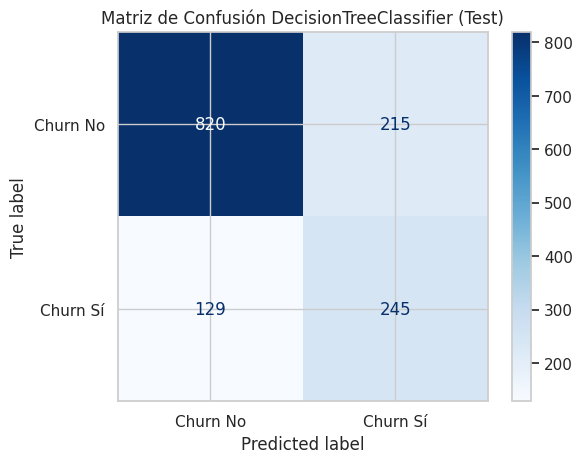

In [94]:
# Predicciones sobre el conjunto de test (que quedó fuera de todo el proceso)
y_previsto = pipeline.predict(X_test)

# Reporte
big_print("Evaluación sobre Pipeline sobre Test:",20,'orange')
print(classification_report(y_test, y_previsto))

# creamos la matriz de confusión
cm = confusion_matrix(y_test, y_previsto)

# creamos el gráfico de la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Churn No', 'Churn Sí'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión DecisionTreeClassifier (Test)')
plt.show()


<font color=red size=4>
¿Qué significa esta matriz de confusión con modelo creado con pipeline, con balanceo y validación cruzada?</font>

1. que predijo correctamente 820 Churn No (Verdaderos Negativos TN) **79%**

2. que predijo erróneamente 215 Churn No como Churn Sí (Falsos Positivos FP)

3. predijo correctamente 245 Churn Sí (Verdaderos Positivos TP) **66%**

4. predijo erróneamente 129 Churn Sí como Churn No (Falsos Negativos FN)

In [95]:
recalls = cv_resultados['test_recall']
intervalo_confianza_recall(recalls)

**¿Qué significa que el recall baje de 66% a 63%?**



*   Significa que el modelo, en promedio, está identificando menos casos positivos correctamente (menos Churn=1).
*   Este descenso indica que las condiciones de evaluación son más estrictas (porque utilizamos validación cruzada con SMOTE dentro del pipeline, que evita sobreajuste y fuga de datos).






**¿Qué significa que el intervalo de confianza sea más estrecho?**


*  Significa que la variabilidad entre las iteraciones de validación es menor
*  El modelo es más consistente en su rendimiento, aunque sea más bajo.






#### <font color=blue size=5>Undersampling</font>

In [96]:
# vamos a probar cómo varía este resultado utilizando undersampling
modelo = DecisionTreeClassifier(max_depth=10,random_state=42)

# creamos lista de tareas del pipeline
tareas = [('undersample', NearMiss(version=3)), ('Árbol', modelo)]

# creamos pipeline
pipeline = imbpipeline(tareas)

# instanciamos el StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(pipeline, X_train, y_train, cv=skf, scoring=['accuracy', 'precision', 'recall', 'f1'])

In [97]:
# generamos dataframe con arreglo cv_results
cv_resultados = pd.DataFrame(cv_results)
cv_resultados

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
0,0.062513,0.013948,0.681455,0.428230,0.598662,0.499303
1,0.064154,0.011616,0.710736,0.468822,0.678930,0.554645
2,0.062799,0.013133,0.702751,0.459091,0.675585,0.546685
3,0.061226,0.026687,0.694765,0.448513,0.655518,0.532609
4,0.061142,0.011498,0.688277,0.444206,0.692308,0.541176


In [98]:
# Entrenamos el pipeline completo con todos los datos de entrenamiento
pipeline.fit(X_train, y_train)


Pipeline(steps=[('undersample', NearMiss(version=3)),
                ('Árbol',
                 DecisionTreeClassifier(max_depth=10, random_state=42))])

              precision    recall  f1-score   support

           0       0.84      0.68      0.75      1035
           1       0.42      0.64      0.51       374

    accuracy                           0.67      1409
   macro avg       0.63      0.66      0.63      1409
weighted avg       0.73      0.67      0.69      1409



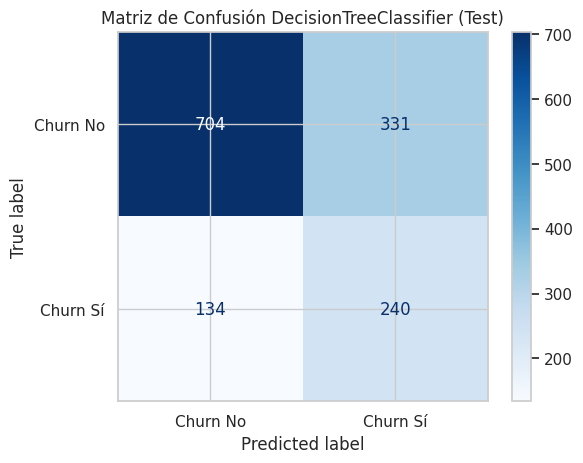

In [99]:
# Predicciones sobre el conjunto de test (que quedó fuera de todo el proceso)
y_previsto = pipeline.predict(X_test)

# Reporte
big_print("\nEvaluación sobre Test Set con undersample:",20,'orange')
print(classification_report(y_test, y_previsto))

# creamos la matriz de confusión
cm = confusion_matrix(y_test, y_previsto)

# creamos el gráfico de la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Churn No', 'Churn Sí'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión DecisionTreeClassifier (Test)')
plt.show()

In [100]:
# el intervalo de confianza para el test_recall

recalls = cv_resultados['test_recall']
intervalo_confianza_recall(recalls)



---
<font color=red size=5>
En este caso el undersampling tuvo peores métricas para el recall de ambas clases</font>



---



### <font color=blue size=5>Validación del modelo usando Oversampling</font>

              precision    recall  f1-score   support

           0       0.86      0.79      0.83      1035
           1       0.53      0.66      0.59       374

    accuracy                           0.76      1409
   macro avg       0.70      0.72      0.71      1409
weighted avg       0.78      0.76      0.76      1409



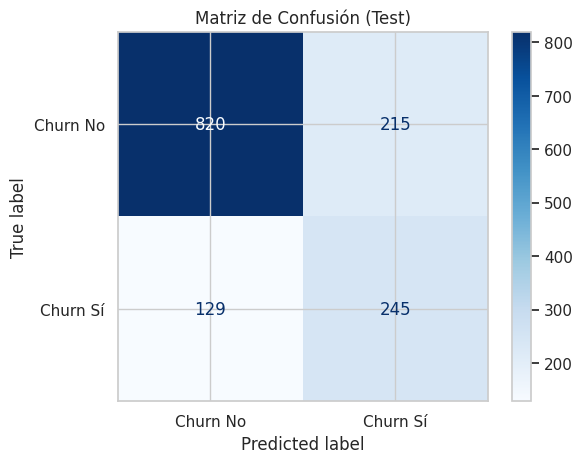

In [101]:
# recapitulemos y probemos el modelo con oversampling

modelo = DecisionTreeClassifier(max_depth=10,random_state=42)

# generamos conjuntos de train balanceados
oversampling = SMOTE(random_state=42)

X_bal, y_bal = oversampling.fit_resample(X_train, y_train)

# entrenamos modelo con conjuntos balanceados
modelo.fit(X_bal, y_bal)

# validamos modelo con test
y_previsto = modelo.predict(X_test)

big_print("\nEvaluación sobre Test con oversampling:",20,'orange')
print(classification_report(y_test, y_previsto))

# creamos la matriz de confusión
cm = confusion_matrix(y_test, y_previsto)

# creamos el gráfico de la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Churn No', 'Churn Sí'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión (Test)')
plt.show()



---
<font color=red size=4>
vemos aquí que el modelo DecisionTreeClassifier predijo correctamente al 66% de los Churn Sí.</font>



---



## <font color=blue size=5>RandomForestClassifier</font>

### <font color=blue size=5>Comparación de RandonForestClassifier con class_weight='balanced' y con SMOTE</font>



---


<font size=4>Ambas opciones se usan para trabajar con clases desbalaceadas</font>


---



In [102]:
def evaluar_modelo_cv(pipeline, X, y, cv):
    reportes_fold = []

    for train_idx, val_idx in cv.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        pipeline.fit(X_tr, y_tr)
        y_pred = pipeline.predict(X_val)

        reporte = classification_report(y_val, y_pred, output_dict=True)
        reportes_fold.append(reporte)

    return pd.DataFrame(reportes_fold)

In [103]:
# Validación cruzada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Modelo 1: RandomForest con class_weight
modelo_weight = RandomForestClassifier(n_estimators=150, max_depth=10,
                                       class_weight='balanced', random_state=42)
pipeline_weight = imbpipeline([('modelo', modelo_weight)])

# Modelo 2: RandomForest con SMOTE
modelo_smote = RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42)
pipeline_smote = imbpipeline([
    ('oversample', SMOTE(random_state=42)),
    ('modelo', modelo_smote)
])

# Evaluamos ambos
reportes_weight = evaluar_modelo_cv(pipeline_weight, X_train, y_train, skf)
reportes_smote = evaluar_modelo_cv(pipeline_smote, X_train, y_train, skf)

In [104]:
# Extraemos métricas por clase
def promediar_metricas(df_reportes):
    clase_0 = df_reportes.apply(lambda x: x['0'], axis=1).apply(pd.Series).mean()
    clase_1 = df_reportes.apply(lambda x: x['1'], axis=1).apply(pd.Series).mean()
    return pd.DataFrame({'Clase 0': clase_0, 'Clase 1': clase_1}).round(3)

promedios_weight = promediar_metricas(reportes_weight)
promedios_smote = promediar_metricas(reportes_smote)

# Mostramos comparación lado a lado
big_print("\nMétricas por clase - class_weight='balanced':")
print(promedios_weight)

big_print("\nMétricas por clase - SMOTE:")
print(promedios_smote)


           Clase 0  Clase 1
precision    0.887    0.568
recall       0.803    0.717
f1-score     0.843    0.634
support    827.800  299.000




           Clase 0  Clase 1
precision    0.870    0.570
recall       0.819    0.662
f1-score     0.844    0.612
support    827.800  299.000




---

<font size=4>RandomForest con class_weight='balance' tiene mejor resultado que la opción con SMOTE</font>


---



In [105]:
# creamos modelo usando RandomForestClassifier con class_weight='balanced'
modelo = RandomForestClassifier(random_state=42,max_depth=5,class_weight='balanced',n_estimators=100,min_samples_leaf=3,min_samples_split=2)

# creamos lista de tareas del pipeline
tareas = [('modelo', modelo)]

# creamos pipeline
pipeline = imbpipeline(tareas)

# instanciamos el StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# revisamos la validación cruzada usando el skf
cv_results = cross_validate(modelo, X_train, y_train, cv=skf, scoring=['accuracy', 'precision', 'recall', 'f1'])

In [106]:
# generamos dataframe con arreglo cv_results
cv_resultados = pd.DataFrame(cv_results)
cv_resultados

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
0,0.356411,0.024559,0.726708,0.490644,0.789298,0.605128
1,0.320883,0.022940,0.756877,0.526427,0.832776,0.645078
2,0.325437,0.024332,0.743567,0.511211,0.762542,0.612081
3,0.349948,0.022850,0.734694,0.500000,0.779264,0.609150
4,0.323162,0.022270,0.720249,0.484496,0.836120,0.613497


###<font color=blue size=5>Optimización de parámetros</font>

In [107]:
# Optimización de RandomForest con GridSearchCV
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1,2,3]
}

# generamos el Kfold de 5 conjuntos
cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(modelo, param_grid, cv=cv, scoring='recall', n_jobs=-1)
grid.fit(X_train, y_train)
print(f"\nMejores parámetros RandomForest: {grid.best_params_}")



Mejores parámetros RandomForest: {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}


### <font color=blue size=5>Modelo RandomForest optimizado</font>

              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1035
           1       0.50      0.80      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409





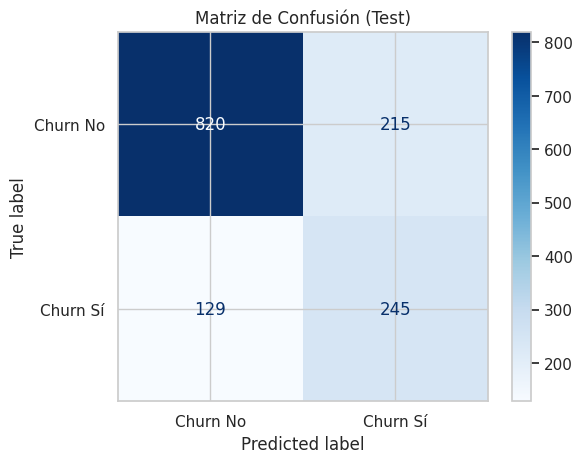

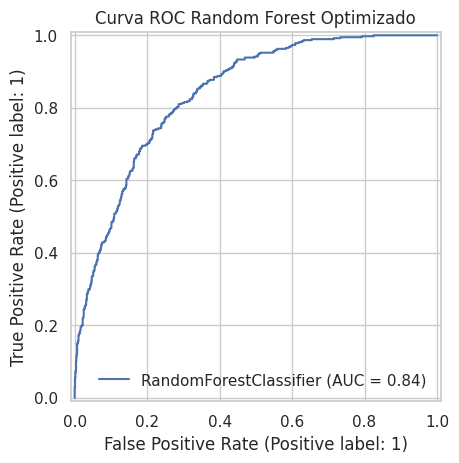

In [108]:
# Evaluación final con el mejor modelo
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

big_print("Reporte Final RandomForest Optimizado:",20,'orange')
print(classification_report(y_test, y_pred))
big_print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.3f}",20,'orange')

# creamos la matriz de confusión
cm = confusion_matrix(y_test, y_previsto)

# creamos el gráfico de la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Churn No', 'Churn Sí'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión (Test)')
plt.show()

RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title('Curva ROC Random Forest Optimizado')
plt.show()


In [109]:
# calculamos intervalo de confianza para este modelo

recalls = cv_resultados['test_recall']
intervalo_confianza_recall(recalls)



---
<font color=red size=4>
El modelo RandomForestClassifier optimizado predijo correctamente al 80% de los Churn Sí.

Predijo correctamente al 71% de los Churn No.</font>


<font color=red size=4>
Este es un modelo aceptable</font>

---



              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1035
           1       0.50      0.80      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409





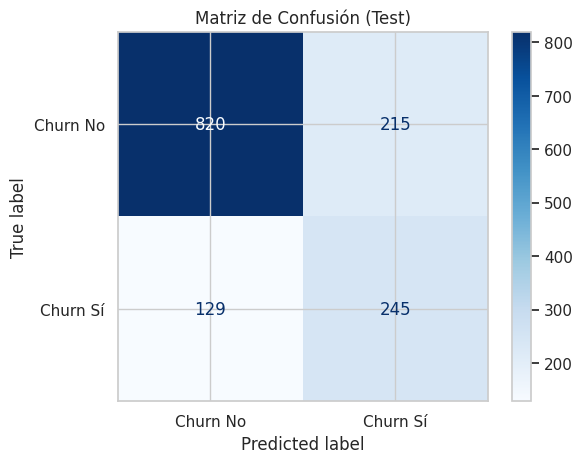

In [110]:
# Definimos el modelo con los mejores parámetros encontrados
rf_model_optimizado = RandomForestClassifier(
    n_estimators=grid.best_params_['n_estimators'],
    max_depth=grid.best_params_['max_depth'],
    min_samples_split=grid.best_params_['min_samples_split'],
    min_samples_leaf=grid.best_params_['min_samples_leaf'],
    class_weight='balanced',
    random_state=42
)

# Creamos el pipeline
pipeline_rf = imbpipeline([
        ('clf', rf_model_optimizado)        # modelo optimizado
])

# Entrenamos el pipeline
pipeline_rf.fit(X_train, y_train)

# Evaluamos test
y_pred_pipe = pipeline_rf.predict(X_test)
y_proba_pipe = pipeline_rf.predict_proba(X_test)[:, 1]

big_print("\nEvaluación con Pipeline RandomForest Optimizado:",20,'orange')
print(classification_report(y_test, y_pred_pipe))
big_print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_pipe):.3f}",20,'orange')

# creamos la matriz de confusión
cm = confusion_matrix(y_test, y_previsto)

# creamos el gráfico de la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Churn No', 'Churn Sí'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión (Test)')
plt.show()

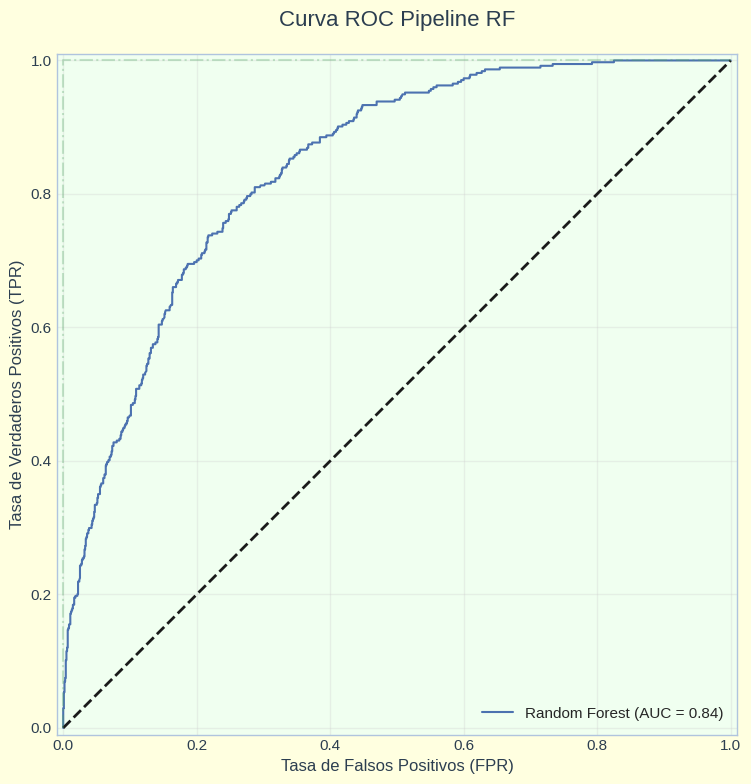

In [111]:
# Configurar el estilo
plt.style.use('seaborn-v0_8-whitegrid')  # Usar un estilo base limpio

# Crear figura con fondo personalizado
plt.figure(figsize=(10, 8), facecolor='lightyellow')  # Color del área de la figura (fondo exterior)

# Generar la curva ROC
ax = plt.gca()  # Obtener el eje actual
ax.set_facecolor('honeydew')  # Color de fondo del área del gráfico (fondo interior)

RocCurveDisplay.from_estimator(pipeline_rf, X_test, y_test, ax=ax, name='Random Forest')

# Personalización adicional
plt.title("Curva ROC Pipeline RF", fontsize=16, color='#2c3e50', pad=20)
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12, color='#2c3e50')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12, color='#2c3e50')

# Personalizar la línea de la curva ROC
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Línea de referencia
plt.plot([0, 0, 1], [0, 1, 1], 'g-.', alpha=0.3)  # Línea de clasificador perfecto

# Personalizar leyenda
legend = plt.legend(loc='lower right')
frame = legend.get_frame()
frame.set_facecolor('honeydew')
frame.set_edgecolor('#b0c4de')
frame.set_alpha(0.9)

# Personalizar ejes y bordes
ax.tick_params(colors='#2c3e50')  # Color de las marcas de los ejes
for spine in ax.spines.values():
    spine.set_color('#b0c4de')  # Color de los bordes del gráfico

# Mejorar la presentación
plt.grid(True, alpha=0.3)
plt.tight_layout()

# guardamos gráfico como archivo png
plt.savefig('curva_roc_pipeline_rf.png', dpi=300, bbox_inches='tight')
plt.show()

In [114]:
# creamos el dataframe feature_importance para identificar cuál es cual
importances = best_model.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns,
                                   'Importances': (importances*100).round(2)})
feature_importance = feature_importance.sort_values(by='Importances', ascending=False)
feature_importance

,Feature,Importances
3,Contract_Month-to-month,33.67
5,Contract_Two year,11.92
1,InternetService_Fiber optic,9.79
24,Charges.Total,9.45
8,PaymentMethod_Electronic check,6.77
2,InternetService_No,6.32
23,Charges.Monthly,5.35
4,Contract_One year,3.65
19,TechSupport,2.20
16,OnlineSecurity,2.09


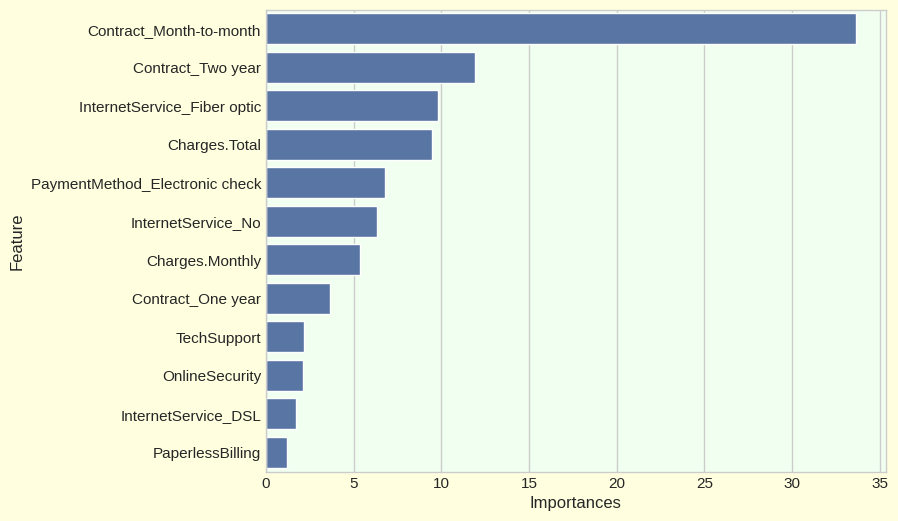

In [118]:
# creamos gráfico de la importancia
plt.figure(figsize=(8, 6), facecolor='lightyellow')
ax = sns.barplot(x='Importances', y='Feature', data=feature_importance.head(12))

# Color del área del gráfico (fondo interior)
ax.set_facecolor('honeydew')

# guardamos gráfico como archivo png
plt.savefig('importancia_varaibles.png', dpi=300, bbox_inches='tight')
plt.show()

### <font color=blue size=5>Feature importance</font>

In [119]:
df_codificados.columns

Index(['InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'Churn',
       'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'Charges.Monthly', 'Charges.Total'],
      dtype='object')

In [120]:
len(df_codificados.columns)

26

In [121]:
best_model.feature_importances_

array([0.0173333 , 0.09794338, 0.0631556 , 0.33670959, 0.03654011,
       0.11915661, 0.00358184, 0.00319202, 0.06765047, 0.00198981,
       0.00170888, 0.00333147, 0.00800481, 0.0060924 , 0.0045649 ,
       0.00253963, 0.02094529, 0.00819535, 0.00507761, 0.02195547,
       0.00444316, 0.00568932, 0.01223753, 0.05350775, 0.09445371])

In [122]:
importances = best_model.feature_importances_

In [123]:
# creamos el dataframe feature_importance para identificar cuál es cual
feature_importance = pd.DataFrame({'Feature': X.columns,
                                   'Importances': (importances*100).round(2)})
feature_importance = feature_importance.sort_values(by='Importances', ascending=False)
feature_importance

,Feature,Importances
3,Contract_Month-to-month,33.67
5,Contract_Two year,11.92
1,InternetService_Fiber optic,9.79
24,Charges.Total,9.45
8,PaymentMethod_Electronic check,6.77
2,InternetService_No,6.32
23,Charges.Monthly,5.35
4,Contract_One year,3.65
19,TechSupport,2.20
16,OnlineSecurity,2.09




---
<font size=4>Solo 12 variables tiene una importancia superior al 1%</font>



---




## <font color=blue size=5>Resumen de creación de pipeline con modelo RandomForest optimizado</font>

In [124]:
# Paso 1: Cargar los datos
df = pd.read_csv("df_normalizado.csv")

# Paso 2: Separar variable target y features
X = df.drop(columns="Churn")  # suponiendo que Churn es la variable objetivo
y = df["Churn"]

# Paso 3: Identificar columnas
columnas_a_eliminar = ['customerID', 'Charges.Total', 'Charges.Monthly', 'tenure']
columnas_binarias = X.columns[X.isin(['Yes', 'No']).any()].tolist()
columnas_categoricas = list(set(X.select_dtypes(include=['object']).columns) - set(columnas_binarias) - set(columnas_a_eliminar))

# Transformer para eliminar columnas
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(columns=self.columns)

# Transformer para mapear Yes/No a 1/0
class YesNoToBinary(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            X[col] = X[col].map({'Yes': 1, 'No': 0})
        return X

# Paso 4: Pipeline de preprocesamiento
preprocesamiento = Pipeline(steps=[
    ('drop_cols', ColumnDropper(columns=columnas_a_eliminar)),
    ('map_binarias', YesNoToBinary(columns=columnas_binarias)),
    ('onehot', ColumnTransformer([
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), columnas_categoricas)
    ], remainder='passthrough'))  # mantener las columnas binarias numéricas
])

# Mejores parámetros RandomForest: {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}

# Paso 5: Pipeline completo con modelo optimizado
modelo_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=3,
    random_state=42,
    class_weight='balanced'
)

pipeline_completo = Pipeline(steps=[
    ('preprocesamiento', preprocesamiento),
    ('clasificador', modelo_rf)
])


              precision    recall  f1-score   support

          No       0.91      0.68      0.78      1035
         Yes       0.48      0.81      0.60       374

    accuracy                           0.71      1409
   macro avg       0.69      0.75      0.69      1409
weighted avg       0.79      0.71      0.73      1409



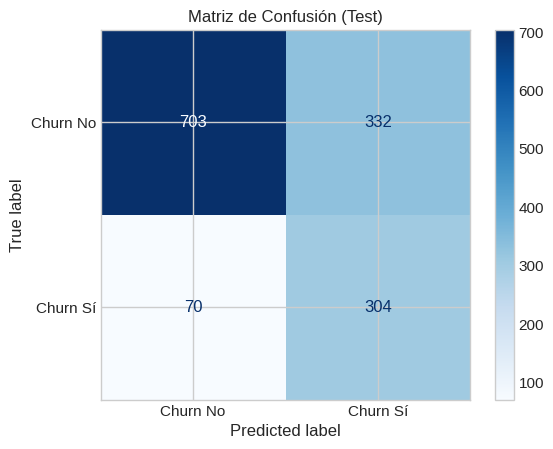

In [125]:
# Separar datos
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

# Entrenar pipeline
pipeline_completo.fit(X_train, y_train)

# Evaluar
y_pred = pipeline_completo.predict(X_test)

big_print("Evaluación de Pipeline RandomForest sobre Test:",20,'orange')
print(classification_report(y_test, y_pred))

# creamos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# creamos el gráfico de la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Churn No', 'Churn Sí'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión (Test)')
plt.show()

In [126]:
# calculemos el intervalo de confianza para la clase 1


## <font color=blue size=5>Exportamos modelo RandomForest optimizado</font>

In [127]:

# Guardar el pipeline entrenado
with open("modelo_randomforest_pipeline.pkl", "wb") as f:
    pickle.dump(pipeline_completo, f)

big_print("✅ Pipeline exportado exitosamente como 'modelo_randomforest_pipeline.pkl'",20,'red')


## <font color=blue size=5>Importamos y usamos modelo</font>


In [128]:
# Cargar el pipeline desde archivo
with open("modelo_randomforest_pipeline.pkl", "rb") as f:
    modelo_cargado = pickle.load(f)

# Usar el modelo cargado para predecir
y_pred_nuevo = modelo_cargado.predict(X_test)

# Evaluamos en test
big_print("Evaluación sobre Test:",20,'orange')
print(classification_report(y_test, y_pred_nuevo))

              precision    recall  f1-score   support

          No       0.91      0.68      0.78      1035
         Yes       0.48      0.81      0.60       374

    accuracy                           0.71      1409
   macro avg       0.69      0.75      0.69      1409
weighted avg       0.79      0.71      0.73      1409



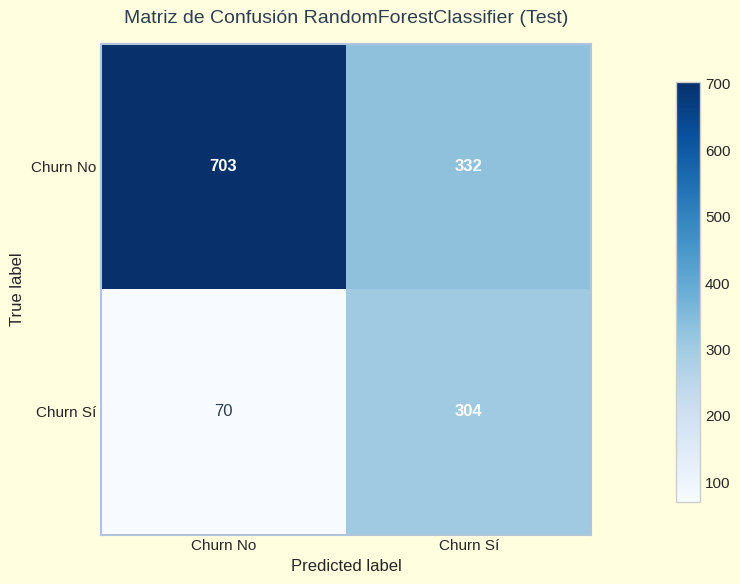

In [129]:
# Crear figura con fondo personalizado
plt.figure(figsize=(8, 6), facecolor='lightyellow')  # Color del área de la figura

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred_nuevo)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Churn No', 'Churn Sí'])

# Personalizar el área del gráfico
ax = plt.gca()
ax.set_facecolor('#e8f4fc')  # Color de fondo del área del gráfico

# Mantener el colormap Blues
disp.plot(cmap='Blues', ax=ax, colorbar=False)

# Personalización adicional
plt.title('Matriz de Confusión RandomForestClassifier (Test)', fontsize=14, pad=15, color='#2c3e50')
plt.grid(False)

# Añadir barra de color personalizada
cax = plt.gcf().add_axes([0.92, 0.15, 0.03, 0.7])
plt.colorbar(disp.im_, cax=cax)

# Cambiar color de los textos según el fondo para mejor contraste
texts = ax.texts
for text in texts:
    # Obtener el valor numérico de la celda
    value = float(text.get_text())
    # Calcular el umbral para cambiar color (ajustar según necesidad)
    threshold = cm.max() * 0.4  # Umbral para cambiar a texto blanco

    # Cambiar a blanco si el valor es alto (fondo oscuro)
    if value > threshold:
        text.set_color('white')
        text.set_weight('bold')  # Hacerlo más legible
    else:
        text.set_color('#2c3e50')  # Color oscuro para fondos claros

# Personalizar bordes
for spine in ax.spines.values():
    spine.set_color('#b0c4de')
    spine.set_linewidth(1.5)

plt.tight_layout()

# guardamos gráfico como archivo png
plt.savefig('matriz_confusion_test.png', dpi=300, bbox_inches='tight')
plt.show()

In [130]:
# registro nuevo para realizar prueba

registro = {
    'customerID': '1234-XYZ',
    'gender': 'Female',
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 0,
    'PhoneService': 'Yes',
    'MultipleLines': 'No',
    'InternetService': 'DSL',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'Yes',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'No',
    'StreamingMovies': 'Yes',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Bank transfer (automatic)',
    'Charges.Monthly': 70.5,
    'Charges.Total': 845.5
}

In [131]:
# Creamos DataFrame con el nuevo registro
df_nuevo = pd.DataFrame([registro])

# Aplicamos modelo predictivo
pred = modelo_cargado.predict(df_nuevo)[0]

#imprimimos valores únicos de df_nuevo solo para las columnas con valor distinto de No
big_print("Cliente:",20)

for col in df_nuevo.columns:
    print(f"{col}: {df_nuevo[col].unique()}")

print('\n')
big_print(f"¿Cliente abandonará?: {'Sí' if pred == 1 else 'No'}",20)

customerID: ['1234-XYZ']
gender: ['Female']
SeniorCitizen: [0]
Partner: ['Yes']
Dependents: ['No']
tenure: [0]
PhoneService: ['Yes']
MultipleLines: ['No']
InternetService: ['DSL']
OnlineSecurity: ['No']
OnlineBackup: ['Yes']
DeviceProtection: ['No']
TechSupport: ['No']
StreamingTV: ['No']
StreamingMovies: ['Yes']
Contract: ['Month-to-month']
PaperlessBilling: ['Yes']
PaymentMethod: ['Bank transfer (automatic)']
Charges.Monthly: [70.5]
Charges.Total: [845.5]






In [132]:
def generar_registro_cliente():
    return {
        'customerID': f'{random.randint(1000, 9999)}-XYZ',
        'gender': random.choice(['Male', 'Female']),
        'SeniorCitizen': random.choice([0, 1]),
        'Partner': random.choice(['Yes', 'No']),
        'Dependents': random.choice(['Yes', 'No']),
        'tenure': 0,
        'PhoneService': random.choice(['Yes', 'No']),
        'MultipleLines': random.choice(['Yes', 'No', 'No phone service']),
        'InternetService': random.choice(['DSL', 'Fiber optic', 'No']),
        'OnlineSecurity': random.choice(['Yes', 'No', 'No internet service']),
        'OnlineBackup': random.choice(['Yes', 'No', 'No internet service']),
        'DeviceProtection': random.choice(['Yes', 'No', 'No internet service']),
        'TechSupport': random.choice(['Yes', 'No', 'No internet service']),
        'StreamingTV': random.choice(['Yes', 'No', 'No internet service']),
        'StreamingMovies': random.choice(['Yes', 'No', 'No internet service']),
        'Contract': random.choice(['Month-to-month', 'One year', 'Two year']),
        'PaperlessBilling': random.choice(['Yes', 'No']),
        'PaymentMethod': random.choice([
            'Electronic check', 'Mailed check',
            'Bank transfer (automatic)', 'Credit card (automatic)'
        ]),
        'Charges.Monthly': 0,
        'Charges.Total': 0
    }


In [133]:
# creación de un registro nuevo para aplicar modelo

registro = generar_registro_cliente()

# Convertir a DataFrame y usar con el modelo
df_nuevo = pd.DataFrame([registro])

#imprimitos columnas con los valores únicos
big_print("Cliente:",20)

for col in df_nuevo.columns:
    print(f"{col}: {df_nuevo[col].unique()}")

# Predecir con el pipeline
pred = modelo_cargado.predict(df_nuevo)[0]
print('\n')
big_print(f"¿Cliente abandonará?: {'Sí' if pred == 1 else 'No'}",20)

customerID: ['7872-XYZ']
gender: ['Male']
SeniorCitizen: [0]
Partner: ['Yes']
Dependents: ['Yes']
tenure: [0]
PhoneService: ['No']
MultipleLines: ['No']
InternetService: ['Fiber optic']
OnlineSecurity: ['Yes']
OnlineBackup: ['No internet service']
DeviceProtection: ['No internet service']
TechSupport: ['No internet service']
StreamingTV: ['No internet service']
StreamingMovies: ['Yes']
Contract: ['One year']
PaperlessBilling: ['Yes']
PaymentMethod: ['Mailed check']
Charges.Monthly: [0]
Charges.Total: [0]






In [134]:
# creamos dataframe con 100 registros nuevos
df_nuevos = pd.DataFrame([generar_registro_cliente() for _ in range(100)])

In [135]:
# guardamos df_nuevos como archivo csv
df_nuevos.to_csv('df_nuevos.csv', index=False)

In [ ]:
df_nuevos

In [136]:
# Generar las predicciones
predicciones = modelo_cargado.predict(df_nuevos)

# Mostrar los resultados
df_resultado = df_nuevos.copy()
df_resultado['Prediccion_Churn'] = predicciones

In [137]:
df_resultado

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total,Prediccion_Churn
0,2152-XYZ,Male,0,No,No,0,No,No phone service,DSL,No internet service,...,Yes,No,Yes,No internet service,Two year,No,Credit card (automatic),0,0,No
1,4900-XYZ,Male,0,Yes,Yes,0,Yes,No phone service,Fiber optic,No,...,No,No internet service,No internet service,No,Month-to-month,No,Bank transfer (automatic),0,0,No
2,1153-XYZ,Male,1,No,No,0,Yes,No,Fiber optic,Yes,...,No,No,No,No internet service,Two year,Yes,Bank transfer (automatic),0,0,No
3,8824-XYZ,Male,0,Yes,Yes,0,Yes,Yes,No,No,...,Yes,Yes,No internet service,No,Two year,No,Mailed check,0,0,No
4,4330-XYZ,Male,0,No,No,0,Yes,No,DSL,No internet service,...,No internet service,No,No internet service,No,Month-to-month,Yes,Credit card (automatic),0,0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6126-XYZ,Male,0,Yes,No,0,Yes,No phone service,No,Yes,...,No,No internet service,Yes,No,Month-to-month,Yes,Bank transfer (automatic),0,0,No
96,3334-XYZ,Male,1,No,No,0,No,Yes,DSL,Yes,...,Yes,No internet service,No,No,One year,No,Mailed check,0,0,No
97,4817-XYZ,Male,0,Yes,No,0,Yes,Yes,DSL,No internet service,...,No,No,No internet service,Yes,Month-to-month,No,Mailed check,0,0,Yes
98,4262-XYZ,Male,0,No,Yes,0,Yes,No phone service,No,Yes,...,No internet service,No,Yes,Yes,Two year,No,Credit card (automatic),0,0,No


In [138]:
# revisamos la proporción de churn
df_resultado['Prediccion_Churn'].value_counts(normalize=True)

,proportion
Prediccion_Churn,
No,0.78
Yes,0.22
